In [1]:
!pip install wrds

     |████████████████████████████████| 2.9MB 14.2MB/s 


In [0]:
import pandas as pd
import wrds

In [5]:
conn = wrds.Connection(wrds_username="kaiyuw")
conn.create_pgpass_file() # then you don't need to enter password next time.
conn.close()

conn = wrds.Connection(wrds_username='kaiyuw')

Enter your WRDS username [root]:kaiyuw
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done
Loading library list...
Done


In [0]:
import pandas as pd
import wrds
# conn = wrds.Connection(wrds_username='shushu17')

import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

In [0]:
# 1. Sample selection
funda = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich
	                  from compa.funda where
	                   (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear<2019 and
                       fyear>2007
                      """) 
company = conn.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 

funda1=pd.merge(funda,company,on=['gvkey'])
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich']>0,funda1['sic'])
funda1=funda1.drop(['sich','sic'],axis=1)
funda1['sic1']=funda1['sic1'].astype(int)

In [0]:
# industry restriction
indexNames =funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index
funda1.drop(indexNames , inplace=True)
indexNames =funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index
funda1.drop(indexNames , inplace=True)

In [0]:
# 2. Variable construction
funda1.describe()
funda1['mv']=funda1['csho']*funda1['prcc_f']
temp = funda1.copy()

In [0]:
# generate lag variables
funda1 = temp.copy()
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

In [13]:
funda1.head()

,gvkey,fyear,ni,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1
0,001004,2008.0,78.651,38.884,14.70,1,571.59480,NaN,NaN
1,001004,2009.0,44.628,39.484,19.70,1,777.83480,78.651,571.59480
2,001004,2010.0,69.826,39.781,26.39,1,1049.82059,44.628,777.83480
3,001004,2011.0,67.723,40.273,12.05,1,485.28965,69.826,1049.82059
4,001004,2012.0,55.000,39.382,20.06,1,790.00292,67.723,485.28965


In [14]:
# generate test variables
funda1=funda1.rename(columns={'ni':'earn'})
    # scale earn with mv_lag1 and earnchg with mv_lag2
funda1=funda1.dropna()
funda1[['earn','mv_lag1']].describe()


,earn,mv_lag1
count,69640.000000,69640.000000
mean,253.671076,4546.964378
std,1688.614432,19980.263131
min,-71969.000000,0.000003
25%,-5.508250,34.005656
50%,2.661000,237.094140
75%,66.889000,1630.579510
max,104821.000000,790050.098120


In [0]:
# winsorize before doing scales.
varlist=['earn','mv_lag1']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
fundax=funda1[['gvkey','fyear','earn_s']]

In [0]:
fundax

,gvkey,fyear,earn_s
1,001000,1975.0,0.499918
2,001000,1976.0,0.374125
3,001000,1977.0,0.151928
10,001001,1984.0,0.043993
11,001001,1985.0,0.192526
...,...,...,...
152637,153954,1990.0,0.027478
152638,153954,1991.0,-0.104000
152639,153954,1992.0,-0.279759
152653,187839,1988.0,-1.884774


In [0]:
# winsorize again for the scaled variables. 
funda2=fundax.dropna()
funda2.describe()

varlist=['earn_s']
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))



In [17]:
# Table 1
destable=funda2.describe().transpose()  # pooled sample
desearn_s=funda2.groupby('fyear')['earn_s'].describe() # Table 1 Panel A
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2009.0,7196.0,-0.229937,0.769085,-3.894488,-0.211563,0.010059,0.080624,0.769967
2010.0,6957.0,-0.092607,0.534760,-3.894488,-0.092762,0.037429,0.084466,0.769967
2011.0,6975.0,-0.073209,0.457155,-3.894488,-0.076399,0.032613,0.076733,0.769967
2012.0,6897.0,-0.090529,0.498447,-3.894488,-0.100277,0.033770,0.081130,0.769967
2013.0,7262.0,-0.117866,0.535016,-3.894488,-0.123378,0.024540,0.075198,0.769967
2014.0,7302.0,-0.130140,0.554068,-3.894488,-0.112419,0.021527,0.062360,0.769967
2015.0,7246.0,-0.160244,0.581683,-3.894488,-0.138569,0.010179,0.057228,0.769967
2016.0,6996.0,-0.168110,0.620608,-3.894488,-0.146582,0.015096,0.064281,0.769967
2017.0,6733.0,-0.130240,0.562298,-3.894488,-0.116045,0.019964,0.062220,0.769967


<function matplotlib.pyplot.show>

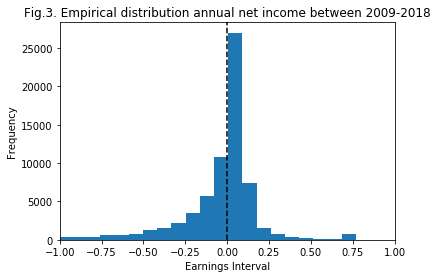

In [22]:
# Figure 3
import matplotlib.pyplot as plt

plt.xlim(-1,1)
plt.hist(funda2['earn_s'], bins=55)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig.3. Empirical distribution annual net income between 2009-2018')
plt.show

In [0]:
# generate lag1 variables
funda1 = temp.copy()
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

In [0]:
# generate lag2 variables
funda1_lag2= funda1[['gvkey','fyear','ni','mv']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag2['fyear']=funda1_lag2['fyear']+2
funda1_lag2=funda1_lag2.rename(columns={'mv':'mv_lag2','ni':'ni_lag2'})

funda1=pd.merge(funda1,funda1_lag2, how='left', on=['gvkey','fyear'])

# Change in Earnings

In [0]:
# generate lag1 variables
funda1 = temp.copy()
funda1_lag1= funda1[['gvkey','fyear','ni']].copy()
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'ni':'ni_lag1'})


# generate lag2 variables
funda1_lag2= funda1[['gvkey','fyear','mv']].copy()
funda1_lag2['fyear']=funda1_lag2['fyear']+2
funda1_lag2=funda1_lag2.rename(columns={'mv':'mv_lag2'})

#Merge table
funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])
funda1=pd.merge(funda1,funda1_lag2, how='left', on=['gvkey','fyear'])

#Show table
funda1[['gvkey','gvkey','ni','ni_lag1','mv_lag2']]
temp_funda1 = funda1.copy()

In [24]:
funda1 = temp_funda1.copy()
funda1=funda1.dropna()
funda1[['ni','ni_lag1','mv_lag2']].describe()

,ni,ni_lag1,mv_lag2
count,58392.000000,58392.000000,58392.000000
mean,281.386942,262.466898,4591.973087
std,1717.567676,1737.217888,19384.319074
min,-23119.000000,-71969.000000,0.000000
25%,-4.913000,-4.929250,36.096475
50%,3.949500,3.462500,251.689200
75%,80.862500,71.752500,1696.068335
max,98806.045000,104821.000000,626550.352840


In [25]:
# winsorize before doing scales.
varlist=['ni','ni_lag1','mv_lag2']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.05,0.05)))
funda1[['ni','ni_lag1','mv_lag2']].describe()

,ni,ni_lag1,mv_lag2
count,58392.000000,58392.000000,58392.000000
mean,135.318266,124.234615,2440.915832
std,338.091460,314.309967,5116.356010
min,-97.106000,-92.000000,3.115200
25%,-4.913000,-4.929250,36.096475
50%,3.949500,3.462500,251.689200
75%,80.862500,71.752500,1696.068335
max,1322.517000,1232.950000,20240.418630


In [0]:
funda1['earn_change']=(funda1['ni']-funda1['ni_lag1'])/funda1['mv_lag2']
fundax=funda1[['gvkey','fyear','earn_change']]

In [27]:
fundax[['earn_change']].describe()

,earn_change
count,58392.000000
mean,-0.017718
std,4.307713
min,-426.956857
25%,-0.030062
50%,0.004425
75%,0.042230
max,346.270544


In [28]:
varlist=['earn_change']
for var in varlist:
    fundax[var] = fundax[var].replace(np.Inf, np.nan)
    fundax[var]=np.where(fundax[var].isnull(), np.nan, winsorize(fundax[var], limits=(0.02,0.02)))
fundax[['earn_change']].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,earn_change
count,58392.000000
mean,0.014396
std,0.254672
min,-0.832836
25%,-0.030062
50%,0.004425
75%,0.042230
max,1.000313


In [29]:
destable=fundax.describe().transpose()  # pooled sample
desearn_s=fundax.groupby('fyear')['earn_change'].describe() # Table 1 Panel A
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2010.0,6645.0,0.064571,0.324416,-0.832836,-0.021809,0.016104,0.113106,1.000313
2011.0,6440.0,0.011421,0.263409,-0.832836,-0.038283,0.004597,0.048954,1.000313
2012.0,6451.0,0.007777,0.219220,-0.832836,-0.031443,0.003939,0.036322,1.000313
2013.0,6456.0,0.009114,0.241001,-0.832836,-0.030120,0.004425,0.038510,1.000313
2014.0,6760.0,0.004334,0.254903,-0.832836,-0.033037,0.004425,0.036734,1.000313
2015.0,6715.0,-0.005083,0.237364,-0.832836,-0.037060,0.001199,0.026522,1.000313
2016.0,6643.0,0.016960,0.234218,-0.832836,-0.022821,0.003720,0.031532,1.000313
2017.0,6473.0,0.013444,0.260296,-0.832836,-0.028102,0.004425,0.043019,1.000313
2018.0,5809.0,0.005880,0.232864,-0.832836,-0.028470,0.004425,0.037711,1.000313


<function matplotlib.pyplot.show>

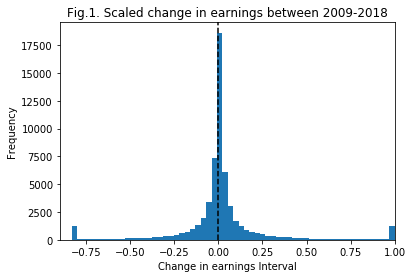

In [32]:
# Figure 3
import matplotlib.pyplot as plt

plt.xlim(-0.9,1)
plt.hist(fundax['earn_change'], bins=60)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig.1. Scaled change in earnings between 2009-2018')
plt.show

In [0]:






# generate test variables
# funda1=funda1.rename(columns={'ni':'earn'})
    # scale earn with mv_lag1 and earnchg with mv_lag2
funda1=funda1.dropna()
funda1[['ni','ni_lag1','mv_lag2']].describe()

,ni,ni_lag1,mv_lag2
count,77254.000000,77254.000000,77254.000000
mean,36.438873,34.112621,497.473205
std,239.887753,229.023264,2350.501952
min,-23498.300000,-23498.300000,0.000000
25%,-0.268000,-0.150000,10.050313
50%,2.121500,2.053000,37.590000
75%,14.320000,13.188500,179.883000
max,6582.000000,6582.000000,95697.499000


In [0]:
varlist=['ni','ni_lag1','mv_lag2']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

# funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
# fundax=funda1[['gvkey','fyear','earn_s']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
funda1['earn_s']=(funda1['ni']-funda1['ni_lag1'])/funda1['mv_lag2']
fundax=funda1[['gvkey','fyear','earn_s']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
fundax

,gvkey,fyear,earn_s
2,001000,1976.0,0.251710
3,001000,1977.0,-0.164075
11,001001,1985.0,0.055590
17,001003,1985.0,-0.010720
18,001003,1986.0,0.075492
...,...,...,...
152641,153954,1988.0,-0.010349
152642,153954,1989.0,-0.000630
152643,153954,1990.0,-0.007284
152644,153954,1991.0,-0.119103


In [0]:
destable=fundax.describe().transpose()  # pooled sample
desearn_s=fundax.groupby('fyear')['earn_s'].describe() # Table 1 Panel A
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
1976.0,3015.0,0.091359,0.762668,-16.056809,-0.004527,0.046578,0.146871,17.037146
1977.0,2938.0,0.052906,0.592184,-10.592589,-0.017603,0.025591,0.085081,13.541684
1978.0,2845.0,0.067652,0.415125,-5.516152,0.001728,0.033055,0.089901,7.992600
1979.0,2787.0,0.032416,0.439352,-9.485797,-0.018179,0.026384,0.081834,6.787168
1980.0,2972.0,-0.013522,0.503011,-9.572694,-0.052800,0.010433,0.057156,8.998543
1981.0,3236.0,0.021953,0.528304,-10.699259,-0.043220,0.013285,0.066551,8.455230
1982.0,3383.0,-0.040127,0.771100,-34.503704,-0.074150,-0.008113,0.032542,7.178971
1983.0,3847.0,0.050444,0.876949,-14.086471,-0.035955,0.016810,0.082652,33.494698
1984.0,3998.0,0.027196,0.611664,-13.969497,-0.037293,0.013222,0.071029,11.253930


In [0]:
# Figure 3
import matplotlib.pyplot as plt

plt.xlim(-0.8,0.8)
plt.hist(xx['earn_s'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig.3. Empirical distribution annual net income')
plt.show

<function matplotlib.pyplot.show>

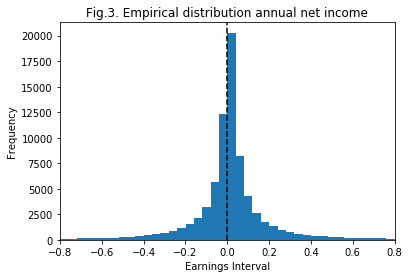

In [0]:
# Figure 3
import matplotlib.pyplot as plt

plt.xlim(-0.8,0.8)
plt.hist(xx['earn_s'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig.3. Empirical distribution annual net income')
plt.show

In [0]:
fundax['earn_s'].describe()

count    77254.000000
mean         0.011728
std          2.399188
min       -346.961611
25%         -0.041204
50%          0.010352
75%          0.064816
max        207.332680
Name: earn_s, dtype: float64

In [0]:
# winsorize before doing scales.
varlist=['earn','mv_lag1']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
fundax=funda1[['gvkey','fyear','earn_s']]

In [0]:
xx = fundax[fundax['earn_s']>-1]

In [0]:
xx = xx[xx['earn_s']<1]

In [0]:
xx['earn_s'].describe()

count    74842.000000
mean         0.011660
std          0.199559
min         -0.998649
25%         -0.038787
50%          0.010129
75%          0.061103
max          0.999782
Name: earn_s, dtype: float64

In [0]:
fundax.shape

(77254, 3)

# Figure 3

In [0]:
funda1 =  temp.copy()

In [0]:

# generate lag variables
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])



In [0]:
funda1

,gvkey,fyear,ni,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1
0,001000,1974.0,2.240,2.150,2.125,3089,4.568750,NaN,NaN
1,001000,1975.0,2.284,2.098,4.375,3089,9.178750,2.240,4.568750
2,001000,1976.0,3.434,2.207,5.750,3089,12.690250,2.284,9.178750
3,001000,1977.0,1.928,2.226,9.250,3089,20.590500,3.434,12.690250
4,001001,1978.0,NaN,NaN,NaN,5812,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
152670,210607,1993.0,NaN,NaN,NaN,1040,NaN,NaN,NaN
152671,210607,1994.0,NaN,NaN,NaN,1040,NaN,NaN,NaN
152672,220508,1993.0,55.034,61.227,23.266,1,1424.507382,NaN,NaN
152673,220508,1994.0,42.840,61.227,16.500,1,1010.245500,55.034,1424.507382


In [0]:
# generate test variables
funda1=funda1.rename(columns={'ni':'earn'})
    # scale earn with mv_lag1 and earnchg with mv_lag2
funda1=funda1.dropna()
funda1[['earn','mv_lag1']].describe()
# winsorize before doing scales.
varlist=['earn','mv_lag1']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
funda1=funda1[['gvkey','fyear','earn_s']]

In [0]:
funda2=funda1.dropna()
funda2.describe()

varlist=['earn_s']
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))



# Table 1
destable=funda2.describe().transpose()  # pooled sample
desearn_s=funda2.groupby('fyear')['earn_s'].describe()

In [0]:
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
1975.0,3138.0,0.130740,0.399155,-1.893193,0.075892,0.181029,0.301879,0.746798
1976.0,3092.0,0.127893,0.338998,-1.893193,0.083724,0.163079,0.254489,0.746798
1977.0,3039.0,0.113652,0.287251,-1.893193,0.079810,0.142893,0.213591,0.746798
1978.0,2950.0,0.142773,0.259866,-1.893193,0.098576,0.156579,0.232311,0.746798
1979.0,3144.0,0.129145,0.269693,-1.893193,0.084145,0.153107,0.226825,0.746798
1980.0,3458.0,0.084865,0.299764,-1.893193,0.050298,0.121157,0.190368,0.746798
1981.0,3623.0,0.060820,0.278468,-1.893193,0.017399,0.089735,0.164700,0.746798
1982.0,4152.0,0.010523,0.313536,-1.893193,-0.033932,0.067269,0.132087,0.746798
1983.0,4413.0,0.007964,0.333015,-1.893193,-0.026981,0.071681,0.135798,0.746798


<function matplotlib.pyplot.show>

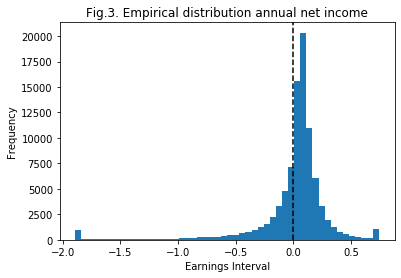

In [0]:
# Figure 3
import matplotlib.pyplot as plt


plt.hist(funda2['earn_s'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig.3. Empirical distribution annual net income')
plt.show